## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# street from Toulouse

# comment/uncomment to download the image
!wget "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640" -O "img.jpg"

# load the image
from PIL import Image
image = Image.open("img.jpg")

# get a torch tensor
torch_image = to_tensor(image)

## Load YOLO

In [4]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")  # pretrained YOLO11n model

In [5]:
CLASSES = list(model.names.values())
nb_classes = len(CLASSES)
print(f"nb classes: {nb_classes}")

nb classes: 80


In [6]:
# resize and batch the image
image = image.resize((640, 640))
visualizable_torch_inputs = to_tensor(image).unsqueeze(0)

# check inference
torch_predictions = model(image)[0]


0: 640x640 7 persons, 2 cars, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 74.8ms postprocess per image at shape (1, 3, 640, 640)


## Obj Detection Wrapper

In [7]:
from xplique.utils_functions.object_detection.torch.box_model_wrapper import YoloBoxesModelWrapper
od_model = YoloBoxesModelWrapper(model)
results = od_model(visualizable_torch_inputs)
results[0].shape

E0000 00:00:1757583664.995490   27594 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757583664.999006   27594 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



0: 640x640 7 persons, 2 cars, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


torch.Size([9, 85])

## Visu YOLO

In [8]:
from xplique.plots.display_image_with_boxes import display_image_with_boxes
from xplique.utils_functions.object_detection.common.box_manager import BoxFormat

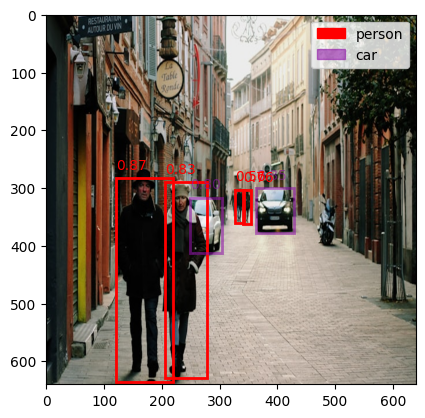

In [9]:
# class labels to color mapping
label_to_color = {'person': 'r',
                  'car': "#8F15A894",
                  'motorcycle': 'y',
                  'bicycle': 'y'}

fig = display_image_with_boxes(image, results[0].cpu().detach(), BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.5)

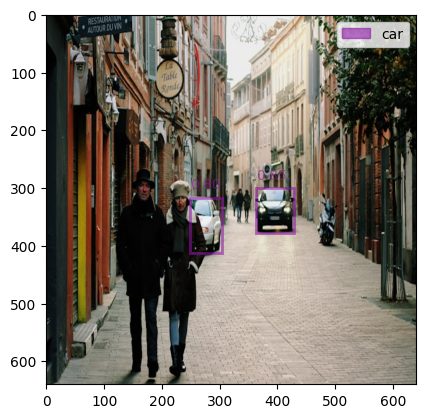

In [10]:
# filter boxes of class 'car'
from xplique.utils_functions.object_detection.torch.box_manager import filter_boxes

filtered_boxes = filter_boxes(results, class_id=CLASSES.index('car'))
fig = display_image_with_boxes(image, filtered_boxes[0].cpu().detach(), BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.5)

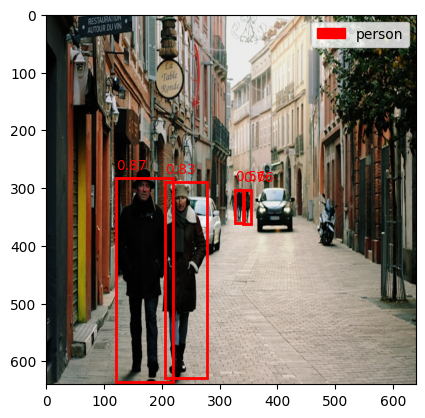

In [11]:
# filter boxes of class 'person'
filtered_boxes = filter_boxes(results, class_id=CLASSES.index('person'))
fig = display_image_with_boxes(image, filtered_boxes[0].cpu().detach(), BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.5)

### WIP: move filter_box to NBCTensor

In [12]:
from xplique.plots.display_image_with_boxes import display_image_with_boxes_nbctensor

In [13]:
# check the filter method in NBCTensor
results.filter(0, accuracy=0.5).shape

torch.Size([1, 6, 85])

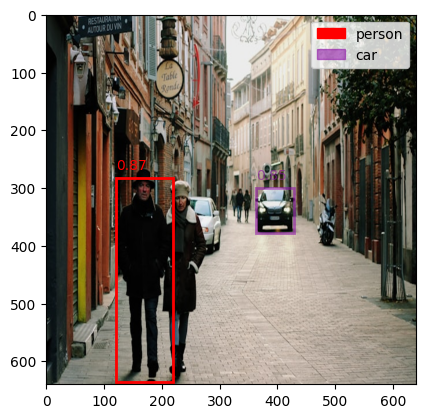

In [14]:
filtered_boxes = results.filter(0, accuracy=0.85)
fig = display_image_with_boxes_nbctensor(image, filtered_boxes, BoxFormat.XYXY, False, CLASSES, label_to_color)

torch.Size([1, 2, 85])


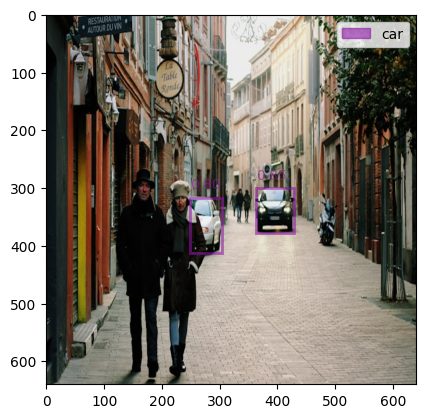

In [15]:
# WIP: move filter_boxes to NBCTensor class
filtered_boxes = results.filter(0, class_id=CLASSES.index('car'))
print(filtered_boxes.shape)
fig = display_image_with_boxes_nbctensor(image, filtered_boxes, BoxFormat.XYXY, False, CLASSES, label_to_color)

# Attribution

In [16]:
# Checks gradients
from xplique.utils_functions.object_detection.torch.gradients_check import check_model_gradients
check = check_model_gradients(od_model.eval(), visualizable_torch_inputs)
print(f"Gradients flow check: {check}")


0: 640x640 7 persons, 2 cars, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Error: element 0 of tensors does not require grad and does not have a grad_fn
Gradients flow check: False


### Test Operators

In [17]:
import xplique
from xplique.wrappers import TorchWrapper

# we need to wrap our model with TorchWrapper to be able to use xplique tools with it
od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [18]:
print(visualizable_torch_inputs.shape)

torch.Size([1, 3, 640, 640])


In [19]:
# transform torch inputs to tensorflow format for Xplique compatibility
tf_inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
tf_inputs = tf_inputs.detach().cpu().numpy()

# inference with the wrapped model
targets = torch_wrapped_model(tf_inputs)

I0000 00:00:1757583671.334163   27594 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8081 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_inputs = self.torch.Tensor(np_inputs)


0: 640x640 7 persons, 2 cars, 57.7ms
Speed: 0.0ms preprocess, 57.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


In [20]:
# check if the Xplique operators work with our wrapped model
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, tf_inputs, targets)
print(scores)


0: 640x640 7 persons, 2 cars, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
tf.Tensor([    0.63043], shape=(1,), dtype=float32)


### Tests Occlusion

In [21]:
from xplique.attributions import Occlusion
explainer = Occlusion(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1, patch_size=(100, 100), patch_stride=(50, 50))

In [22]:
tf_inputs.shape

(1, 640, 640, 3)

In [23]:
box_to_explain = targets[:, 0]
print(f"targets.shape: {targets.shape}")
print(f"box_to_explain.shape: {box_to_explain.shape}")

targets.shape: (1, 9, 85)
box_to_explain.shape: (1, 85)


In [24]:
explanations = explainer.explain(tf_inputs, box_to_explain)


0: 640x640 7 persons, 2 cars, 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.9ms
Speed: 0.0ms prep

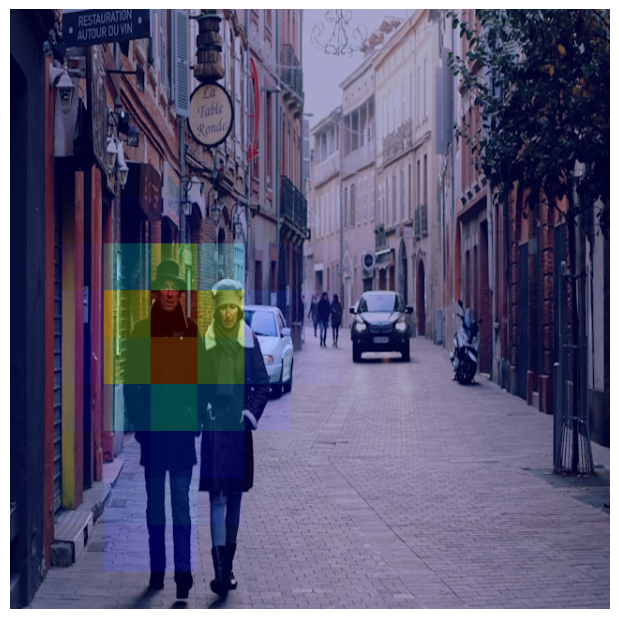

In [25]:
from xplique.plots import plot_attributions, plot_attribution

plot_attributions(explanations, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

In [26]:
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes as filter_boxes_tf
boxes_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('car'))


0: 640x640 7 persons, 2 cars, 11.7ms
Speed: 0.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 cars, 11.0ms
Speed: 0.0ms prep

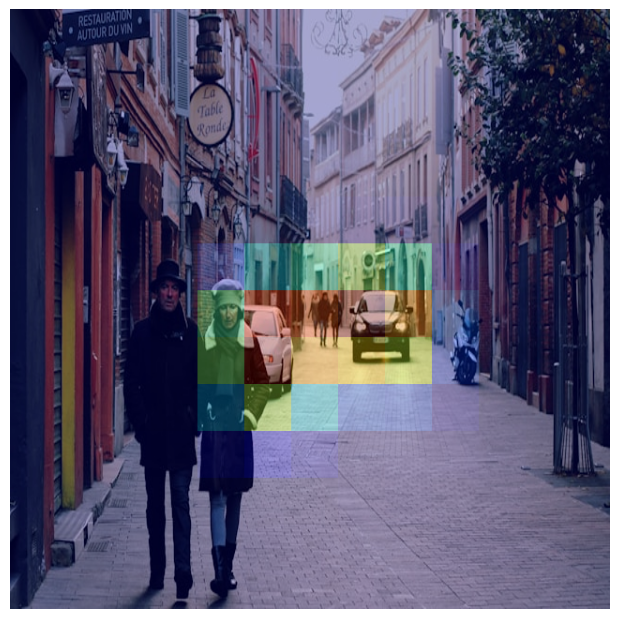

In [27]:
explanations = explainer.explain(tf_inputs, boxes_to_explain)
plot_attributions(explanations, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

### Test Saliency

First we need to make our YOLO support gradients

TODO

In [28]:
from xplique.attributions import Saliency
explainer = Saliency(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1)

In [29]:
box_to_explain = targets[:, 0]
print(f"targets.shape: {targets.shape}")
print(f"box_to_explain.shape: {box_to_explain.shape}")

targets.shape: (1, 9, 85)
box_to_explain.shape: (1, 85)


In [30]:
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes as filter_boxes_tf
box_to_explain_car = filter_boxes_tf(targets, class_id=CLASSES.index('car'))
print(len(box_to_explain_car))
print(f"box_to_explain_car[0].shape: {box_to_explain_car[0].shape}")

1
box_to_explain_car[0].shape: (2, 85)


In [31]:
try:
    explanation = explainer.explain(tf_inputs, box_to_explain)
except Exception as e:
    print("Error during explanation:", e)


0: 640x640 7 persons, 2 cars, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Exception in GradientTape.gradient:  element 0 of tensors does not require grad and does not have a grad_fn
Error during explanation: element 0 of tensors does not require grad and does not have a grad_fn
